C:\Users\25759\AppData\Local\Temp\ipykernel_17868\2836574928.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Firm_attr['Product_Code'] = firm_product


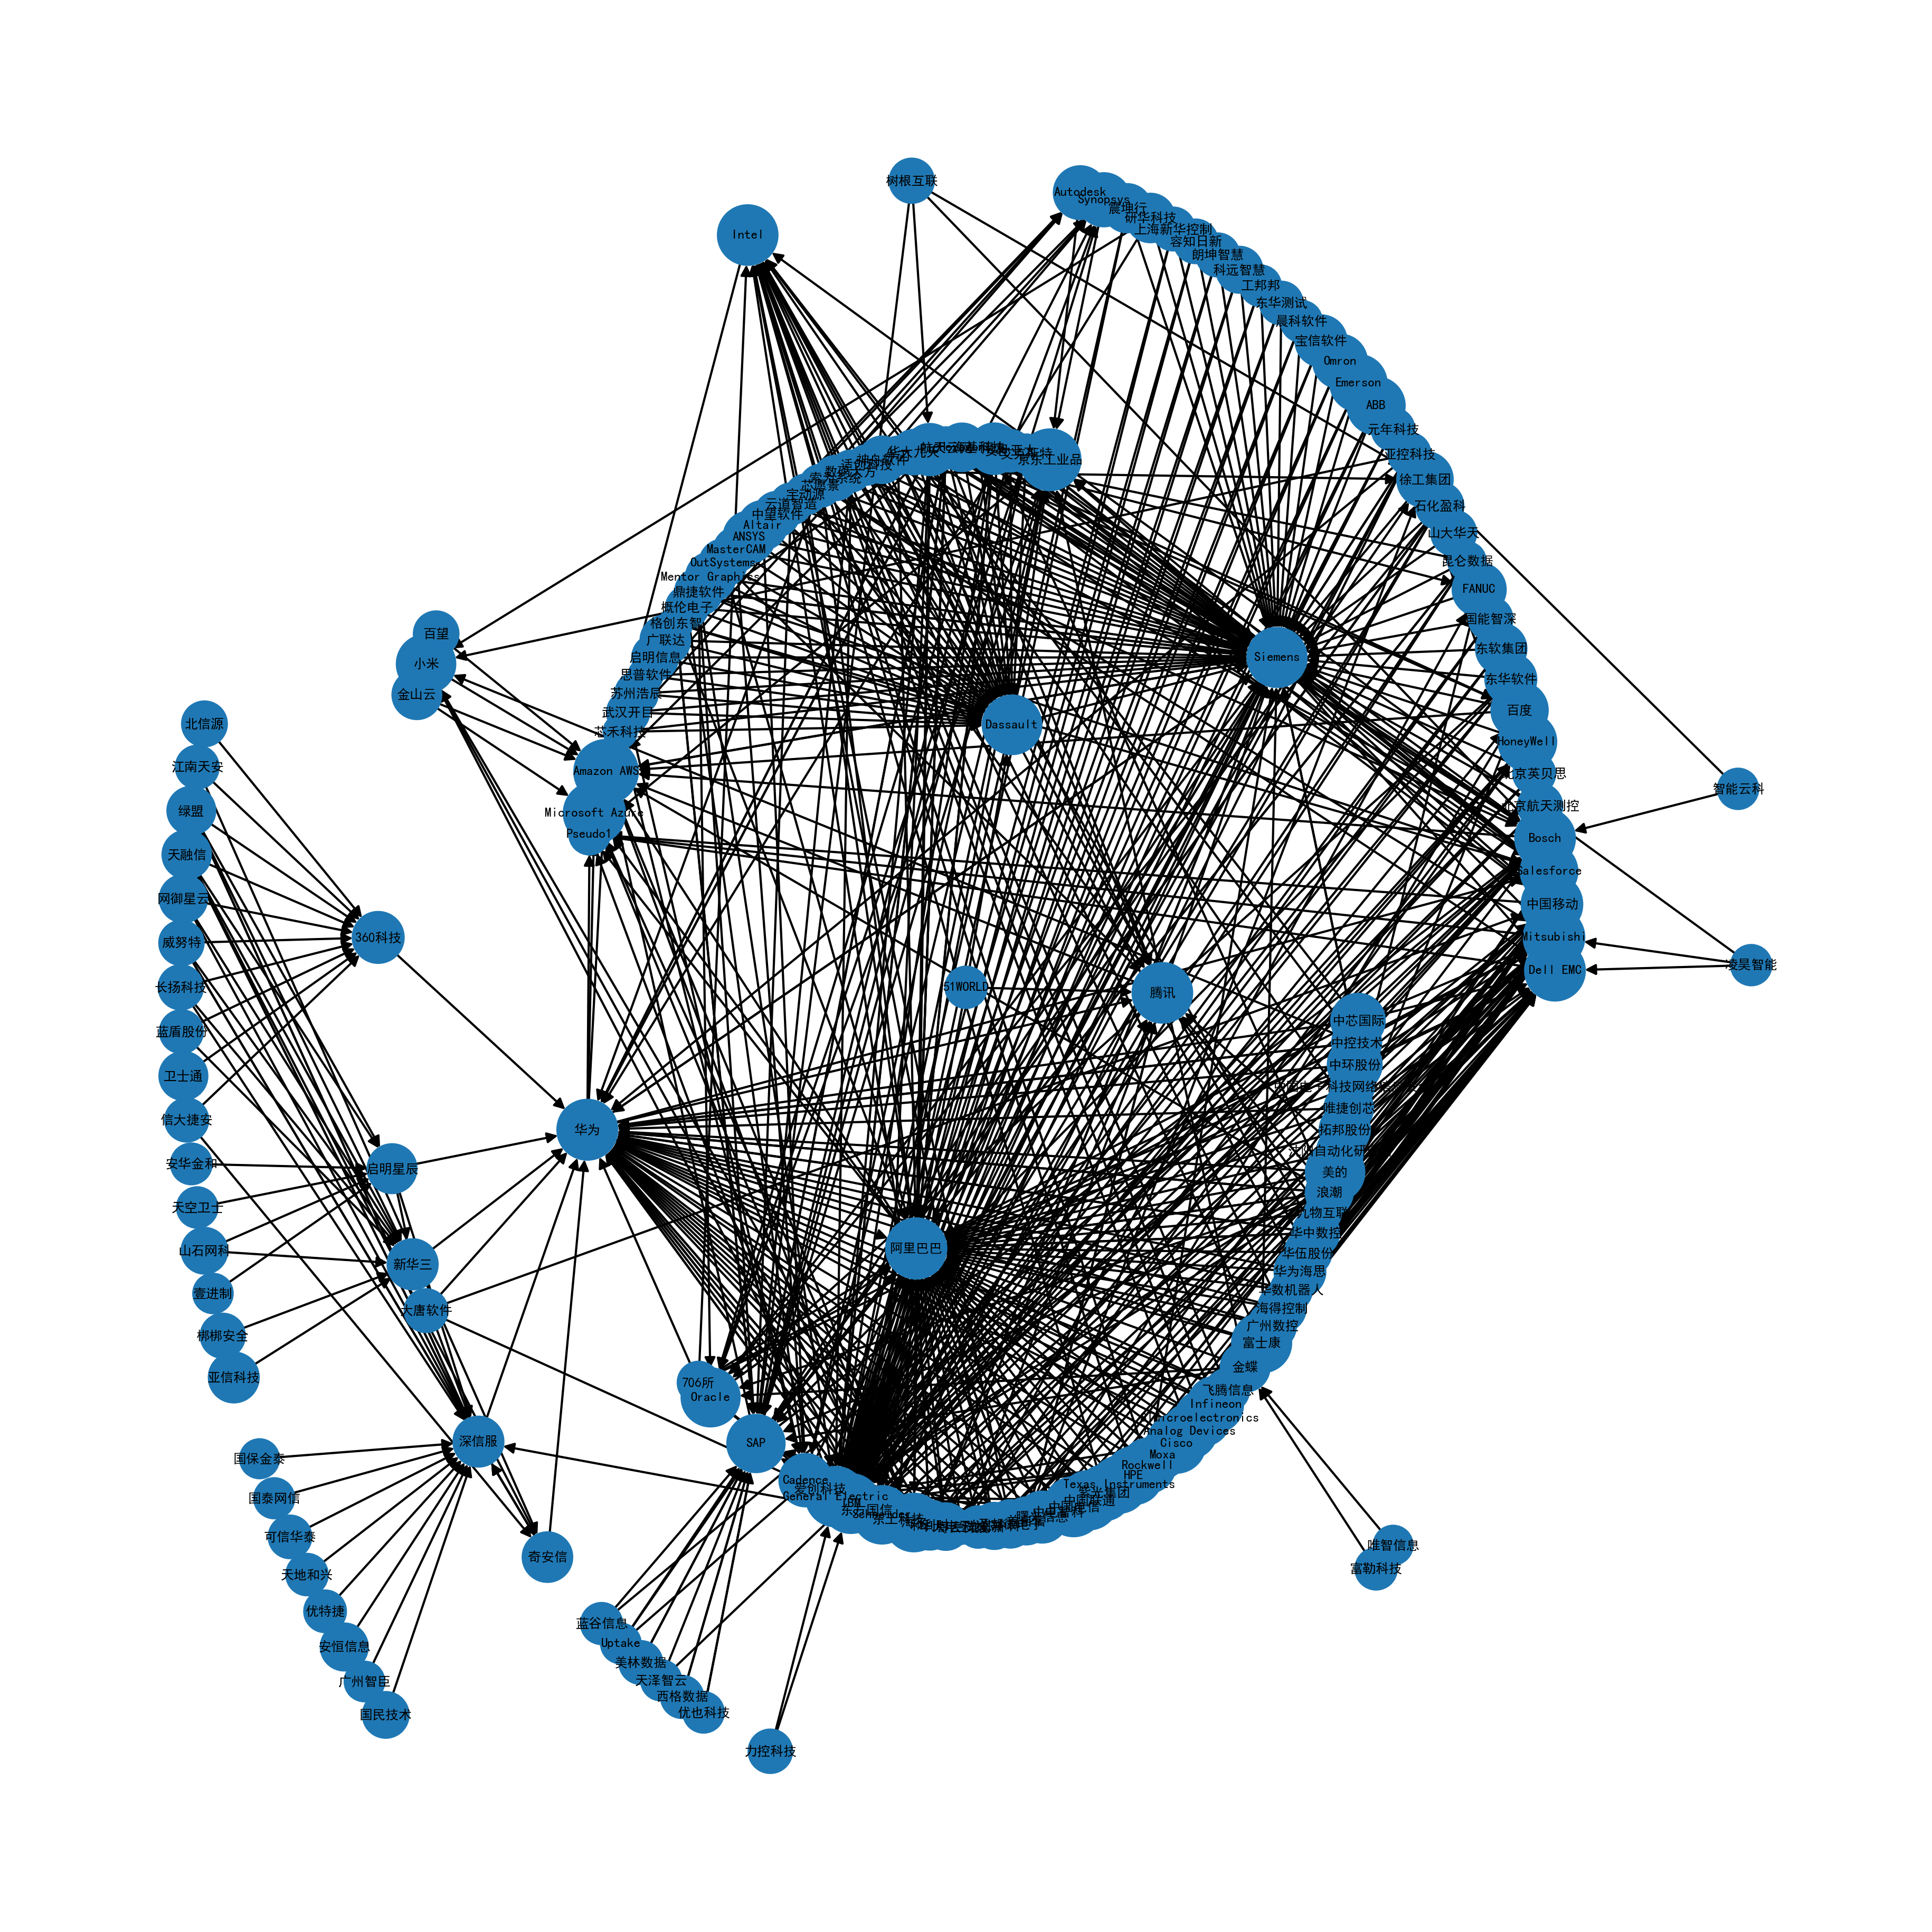

In [6]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt


seed = 0
np.random.seed (seed)
plt.rcParams['font.sans-serif'] = 'SimHei'

# init graph bom
BomNodes = pd.read_csv('BomNodes.csv', index_col=0)
BomNodes.set_index('Code', inplace=True)
BomCateNet = pd.read_csv('BomCateNet.csv', index_col=0)
BomCateNet.fillna(0, inplace=True)

G_bom = nx.from_pandas_adjacency(BomCateNet, create_using=nx.MultiDiGraph())

bom_labels_dict = {}
for code in G_bom.nodes:
    bom_labels_dict[code] = BomNodes.loc[code].to_dict()
nx.set_node_attributes(G_bom, bom_labels_dict)

# init graph firm
Firm = pd.read_csv("Firm_amended.csv")
Firm.fillna(0, inplace=True)
Firm_attr = Firm[["Code","Name","Type_Region", "Revenue_Log"]]
firm_product = []
for _, row in Firm.loc[:,'1':].iterrows():
    firm_product.append(row[row==1].index.to_list())
Firm_attr['Product_Code'] = firm_product
Firm_attr.set_index('Code')

G_Firm =nx.MultiDiGraph()
G_Firm.add_nodes_from(Firm["Code"])

firm_labels_dict = {}
for code in G_Firm.nodes:
    firm_labels_dict[code] = Firm_attr.loc[code].to_dict()
nx.set_node_attributes(G_Firm, firm_labels_dict)

# add edge to G_firm according to G_bom
for node in nx.nodes(G_Firm):
    # print(node, '-'*20)
    list_pred_product_code = []
    for product_code in G_Firm.nodes[node]['Product_Code']:
        list_pred_product_code += list(G_bom.predecessors(product_code))
    list_pred_product_code = list(set(list_pred_product_code))
    for pred_product_code in list_pred_product_code:
        # print(pred_product_code)
        list_pred_firms = Firm.index[Firm[pred_product_code]==1].to_list()
        list_revenue_log = [G_Firm.nodes[pred_firm]['Revenue_Log'] for pred_firm in list_pred_firms]
        list_prob = [(v - min(list_revenue_log)+1)/(max(list_revenue_log)-min(list_revenue_log)+1) for v in list_revenue_log]
        list_flag = [np.random.choice([1,0],p=[prob, 1-prob]) for prob in list_prob]
        # print(list(zip(list_pred_firms,list_flag, list_prob)))
        list_added_edges = [(node, pred_firm) for pred_firm, flag in zip(list_pred_firms, list_flag) if flag==1]
        G_Firm.add_edges_from(list_added_edges)
    # print('-'*20)

# print graph
pos = nx.nx_agraph.graphviz_layout(G_Firm, prog="twopi", args="")
node_label = nx.get_node_attributes(G_Firm, 'Name')
node_size = list(nx.get_node_attributes(G_Firm, 'Revenue_Log').values())
node_size = list(map(lambda x: x**2, node_size))
plt.figure(figsize=(12, 12), dpi=300)
nx.draw(G_Firm, pos, node_size=node_size, labels=node_label, font_size=6)
plt.show()

In [2]:
G_bom.nodes()

NodeView(('1', '1.1', '1.1.1', '1.1.2', '1.1.3', '1.2', '1.2.1', '1.2.2', '1.2.3', '1.3', '1.3.1', '1.3.1.1', '1.3.1.2', '1.3.1.3', '1.3.1.4', '1.3.1.5', '1.3.1.6', '1.3.1.7', '1.3.2', '1.3.2.1', '1.3.3', '1.3.3.1', '1.3.3.2', '1.3.3.3', '1.3.3.4', '1.3.3.5', '1.3.3.6', '1.3.3.7', '1.3.4', '1.3.4.1', '1.3.4.2', '1.3.4.3', '1.3.5', '1.3.5.1', '1.4', '1.4.1', '1.4.1.1', '1.4.1.2', '1.4.1.3', '1.4.1.4', '1.4.1.5', '1.4.2', '1.4.2.1', '1.4.2.2', '1.4.2.3', '1.4.2.4', '1.4.2.5', '1.4.2.6', '1.4.2.7', '1.4.3', '1.4.3.1', '1.4.3.2', '1.4.3.3', '1.4.3.4', '1.4.3.5', '1.4.3.6', '1.4.4', '1.4.4.1', '1.4.4.2', '1.4.4.3', '1.4.4.4', '1.4.4.5', '1.4.5', '1.4.5.1', '1.4.5.2', '1.4.5.3', '1.4.5.4', '1.4.5.5', '1.4.5.6', '1.4.5.7', '1.4.5.8', '1.4.5.9', '2', '2.1', '2.1.1', '2.1.1.1', '2.1.1.2', '2.1.1.3', '2.1.1.4', '2.1.1.5', '2.1.2', '2.1.2.1', '2.1.2.2', '2.1.2.3', '2.1.2.4', '2.1.3', '2.1.3.1', '2.1.3.2', '2.1.3.3', '2.1.3.4', '2.1.3.5', '2.1.3.6', '2.1.3.7', '2.1.4', '2.1.4.1', '2.1.4.1.1', '2.1

In [3]:
list(G_bom.neighbors('1'))

['1.1', '1.2', '1.3', '1.4', '2']